# Lecture 21 EEP118 - 2024

## Difference in Differences

Rollout of Program and Panel
     
Research Question: do changes in traffic law affect fatalities in the US?

This is the datahub notebook see also R code in Bcourses and data set

Study chapter 4, DeJanvry and Sadoulet Book, posted on B courses

Study Wooldridge Chapter 13.2



### Research Question: Do change in traffic laws cause changes/ affect traffic fatalities?

Freeman, D.G. (2007) “Drunk Driving Legislation and Traffic Fatalities: New evidence on the BAC 08 Laws” Contemporary Economic Policy 25, 293-308

State level analysis, using 25 years of data from 1980 to 2004, with changes in various state drunk driving, seat belt, and speed limit laws. 






In [1]:
# Load the 'pacman' package
library(pacman) 
#packages to use load them now using the pacman "manager"
p_load(dplyr, haven, readr) 
#Another great feature of p_load(): if you try to load a package that is not installed on your machine, p_load() install the package for you, rather than throwing an error. For instance, let’s install and load one final package named ggplot2. 
p_load(ggplot2)


pacman::p_load(lfe, lmtest, haven, sandwich, tidyverse)
# lfe for running fixed effects regression
# lmtest for displaying robust SE in output table
# haven for loading in dta files
# sandwich for producing robust Var-Cov matrix
# tidyverse for manipulating data and producing plots


#change into Lecture 19 directory
#setwd("/Users/sofiavillas-boas/Dropbox/EEP118_Spring2023/Lectures/Lecture19")


pacman::p_load(lfe, haven, tidyverse)




In [2]:
#read in a Stata dataset DATA LECTURE 21

lec21df <- read_dta("Lecture21_driving.dta")

perse           administrative license revocation

                (per se law)

totfatrte       total fatalities per 100,000 population

year            1980 to 2004

state           48 continental states, alphabetical



In [3]:
# summarize data
summary(lec21df)

      year          state            sl55             sl65       
 Min.   :1980   Min.   : 1.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1986   1st Qu.:15.75   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1992   Median :27.50   Median :0.0000   Median :0.0000  
 Mean   :1992   Mean   :27.15   Mean   :0.3533   Mean   :0.4399  
 3rd Qu.:1998   3rd Qu.:39.25   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :2004   Max.   :51.00   Max.   :1.0000   Max.   :1.0000  
      sl70            sl75             slnone            seatbelt    
 Min.   :0.000   Min.   :0.00000   Min.   :0.000000   Min.   :0.000  
 1st Qu.:0.000   1st Qu.:0.00000   1st Qu.:0.000000   1st Qu.:0.000  
 Median :0.000   Median :0.00000   Median :0.000000   Median :1.000  
 Mean   :0.119   Mean   :0.08024   Mean   :0.007569   Mean   :1.116  
 3rd Qu.:0.000   3rd Qu.:0.00000   3rd Qu.:0.000000   3rd Qu.:2.000  
 Max.   :1.000   Max.   :1.00000   Max.   :1.000000   Max.   :2.000  
     minage        zerotol            gdl       

In [4]:
# add in passed variable, whether per se law will be eventually passed by state
#passed = maximum by state of the perse column
#if max=1 then passed, if max=0 never passed

lec21df <- lec21df %>%
  group_by(state) %>%
  mutate(passed = max(perse)) %>%
  ungroup()

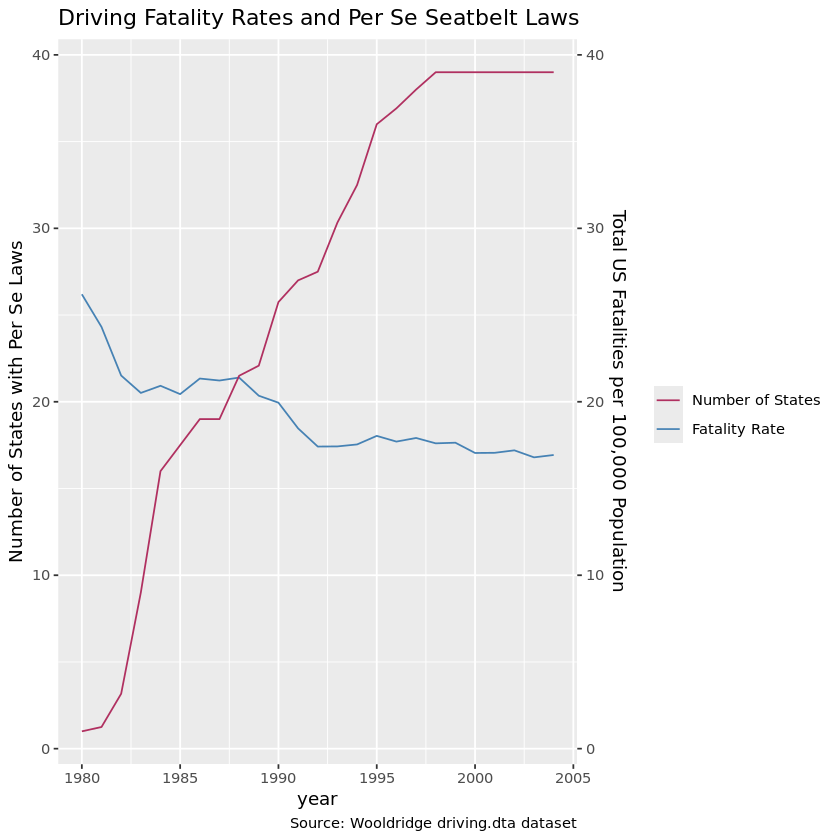

In [5]:
#Plot 1

# Make a graph of evolution of number of states per year with per se laws
# evolution of us fatalities 

# make the aggregated data
plot1df <- lec21df %>%
  # drop obs for passed == 0
  filter(passed ==1) %>%
  # create sum of perse and mean of totfatrte per year
  group_by(year) %>%
  summarize(sum_perse = sum(perse),
         mean_totfatrte = mean(totfatrte)) %>%
  ungroup()

# produce the plot
ggplot(plot1df, aes(x = year)) +
  # add totfatrte line
  geom_line(aes(y = mean_totfatrte, color = "steelblue")) +
  # add perse line
  geom_line(aes(y = sum_perse, color = "maroon")) +
 # scale_y_continuous lets us name the y-axis and generate a secondary axis
 scale_y_continuous(
    "Number of States with Per Se Laws", 
    sec.axis = sec_axis(~., name = "Total US Fatalities per 100,000 Population")
  ) + 
  # add title
  labs(title = "Driving Fatality Rates and Per Se Seatbelt Laws",
       caption = "Source: Wooldridge driving.dta dataset") +
  scale_colour_manual(name = "",
                      values = c("maroon" = "maroon", "steelblue"="steelblue"),
                      labels = c("Number of States", "Fatality Rate"))

  

Looking at the graph above, and at the red line first, it gives you the number of states with Per Se laws each year. 

We see that more and more states adopt these laws 


  Looking ow at the blue line, measuring the total US (country total) fatalities per 100K people, we see that rate going down over the years.


Putting the two evolutions together, as the number of states with per se laws increases over the years we see the drop in  the total US (country total) fatalities per 100K people rate over the years.

There is also a Selection Effect: States with the higher level of fatalities introduced these laws.



## Graph the evolution of total fatalities by year over time separately for states that will have perse laws and for those that never have perse laws 


In [6]:
####### Plot 2 -------
plot2df <- lec21df %>%
  # mutate passed into a character (so ggplot reads it as discrete)
  mutate(passed = as.character(passed)) %>%
  # generate avg fatality rate by year and passed
  group_by(passed, year) %>%
  summarize(mean_totfatrte = mean(totfatrte)) %>%
  ungroup()

`summarise()` has grouped output by 'passed'. You can override using the
`.groups` argument.


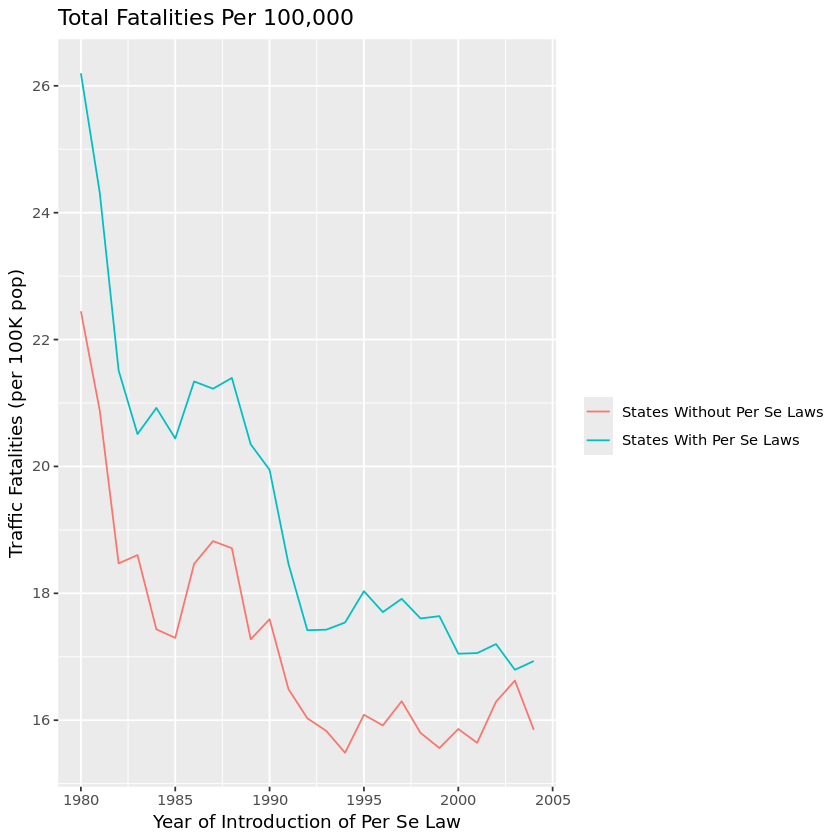

In [7]:
# produce plot
ggplot(plot2df, aes(x = year, y = mean_totfatrte, group = passed, color = passed)) +
  # add totfatrte line
  geom_line() +
  # specify legend
  scale_color_discrete(name="",
                       breaks=c("0", "1"),
                       labels=c("States Without Per Se Laws", "States With Per Se Laws")) +
  # add title, label axes
  labs(title = "Total Fatalities Per 100,000",
       x = "Year of Introduction of Per Se Law",
       y = "Traffic Fatalities (per 100K pop)") +
  # set y ticks
  scale_y_continuous(breaks = c(14, 16, 18, 20, 22 ,24 ,26)) 



What do you see?

1. Obvious time trend, even in states with no introduction of laws. 

Can we attribute their faster decline in fatalities to the law? 






## Regression

Lets estimate a regression model to investigate whether passing the traffic perse law had an effect on fatalities 


Lets consider the relationship between fatalities and perse laws over time and across the states in the data using T years 


Model- state j  year t

 fatalities_𝑗𝑡=  𝛽_1  perse_𝑗𝑡 + {aj } + {𝑑𝑡 } + 𝑣_𝑗𝑡


perse laws marginal effect: (𝝏 fatalities)/(perse 𝟎 𝒕𝒐 𝟏)  = 𝛽_1  change in fatalities, controlling for constant factors by states and factors common to all states by year, with state fixed effects, and also year fixed effects, respectively.

aj captures all the characteristics of state j that are constant over time and affect fatalities -> that is, it controls for the overall level of fatalities in state j, a state fixed effect. 

dt captures overall time patterns, year by year, that is the factors changing over time, that change year by year that affect fatalities and that are common to all states, a year fixed effect. 


Short writing for one dummy for ALL BUT ONE state:  a2,  a3, …,aS.

And one dummy for all but ONE year (d1, d2, …dT)  exclude one year




 --->  constant 𝛽_0  is excluded year (when all   other dyears=0 in excluded state the average fatalities




In [8]:
####### Panel analysis -------
# suppressing fixed effects , but controlling for them use felm()
reg <- felm(totfatrte ~ perse | year + state, data = lec21df)
summary(reg)



Call:
   felm(formula = totfatrte ~ perse | year + state, data = lec21df) 

Residuals:
   Min     1Q Median     3Q    Max 
-9.178 -1.114 -0.042  1.030 14.949 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
perse  -1.8483     0.2424  -7.625 5.15e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.237 on 1127 degrees of freedom
Multiple R-squared(full model): 0.884   Adjusted R-squared: 0.8766 
Multiple R-squared(proj model): 0.04906   Adjusted R-squared: -0.01169 
F-statistic(full model):119.3 on 72 and 1127 DF, p-value: < 2.2e-16 
F-statistic(proj model): 58.15 on 1 and 1127 DF, p-value: 5.151e-14 



We see that perse from 0 to 1 reduced fatalities by  -1.8483  per 100 000  

std error 0.2424       t stat= -7.625       p value 5.15e-14 ***

Significantly. Significant at 1% level. p value is p-value: p value 5.15e-14 ***


In [9]:
#show the fixed effects, can move to main formula as factor(var) to see coefficients and use lm()
regn <- lm(totfatrte ~ perse+ factor(year) + factor(state), data = lec21df)
summary(regn)


Call:
lm(formula = totfatrte ~ perse + factor(year) + factor(state), 
    data = lec21df)

Residuals:
   Min     1Q Median     3Q    Max 
-9.178 -1.114 -0.042  1.030 14.949 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       31.0133     0.5498  56.409  < 2e-16 ***
perse             -1.8483     0.2424  -7.625 5.15e-14 ***
factor(year)1981  -1.8147     0.4566  -3.975 7.49e-05 ***
factor(year)1982  -4.4686     0.4567  -9.785  < 2e-16 ***
factor(year)1983  -5.0336     0.4583 -10.982  < 2e-16 ***
factor(year)1984  -4.6495     0.4628 -10.047  < 2e-16 ***
factor(year)1985  -5.0078     0.4641 -10.790  < 2e-16 ***
factor(year)1986  -4.0011     0.4655  -8.595  < 2e-16 ***
factor(year)1987  -4.0267     0.4655  -8.650  < 2e-16 ***
factor(year)1988  -3.8136     0.4681  -8.146 9.90e-16 ***
factor(year)1989  -4.9105     0.4688 -10.474  < 2e-16 ***
factor(year)1990  -5.0364     0.4734 -10.640  < 2e-16 ***
factor(year)1991  -6.3987     0.4751 -13.469  < 2e-16 **

Again, We see that perse from 0 to 1 reduced fatalities by  -1.8483 per 100 000   

std error 0.2424       t stat= -7.625       p value 5.15e-14 ***

Significantly. Significant at 1% level. p value is p-value: p value 5.15e-14 ***


1. constant estimate means (Intercept)       31.0133 means that fatalities in 1980 in omitted state are on average 31.0133 per 100 000 


2. a negative year fixed effect for 1981 for example,  means that on average fatalities were lower than in 1980, the ommitted year


3. A positive state 25 estimated fixed effect means that state 25 had significantly more fatalities per 100 000 than the omitted state


4. vice versa for a negative state fixed effect, for example, state 24. State 24 had significantly less fatalities per 100 000 on average than the omitted state



## Key Assumptions for the validity of the method


The annual change in the comparison group is a good counterfactual for the annual change in the treatment group

We should be concerned with 3 types of omitted variables:

(i) the trends are different across states and correlated with the timing of Policy

(ii) Policy is implemented in response to a shock (a large increase in casualties)

(iii) Standard Omitted Variable Bias:  States implement other policies at the same time


# Visual Dif in Dif in this case


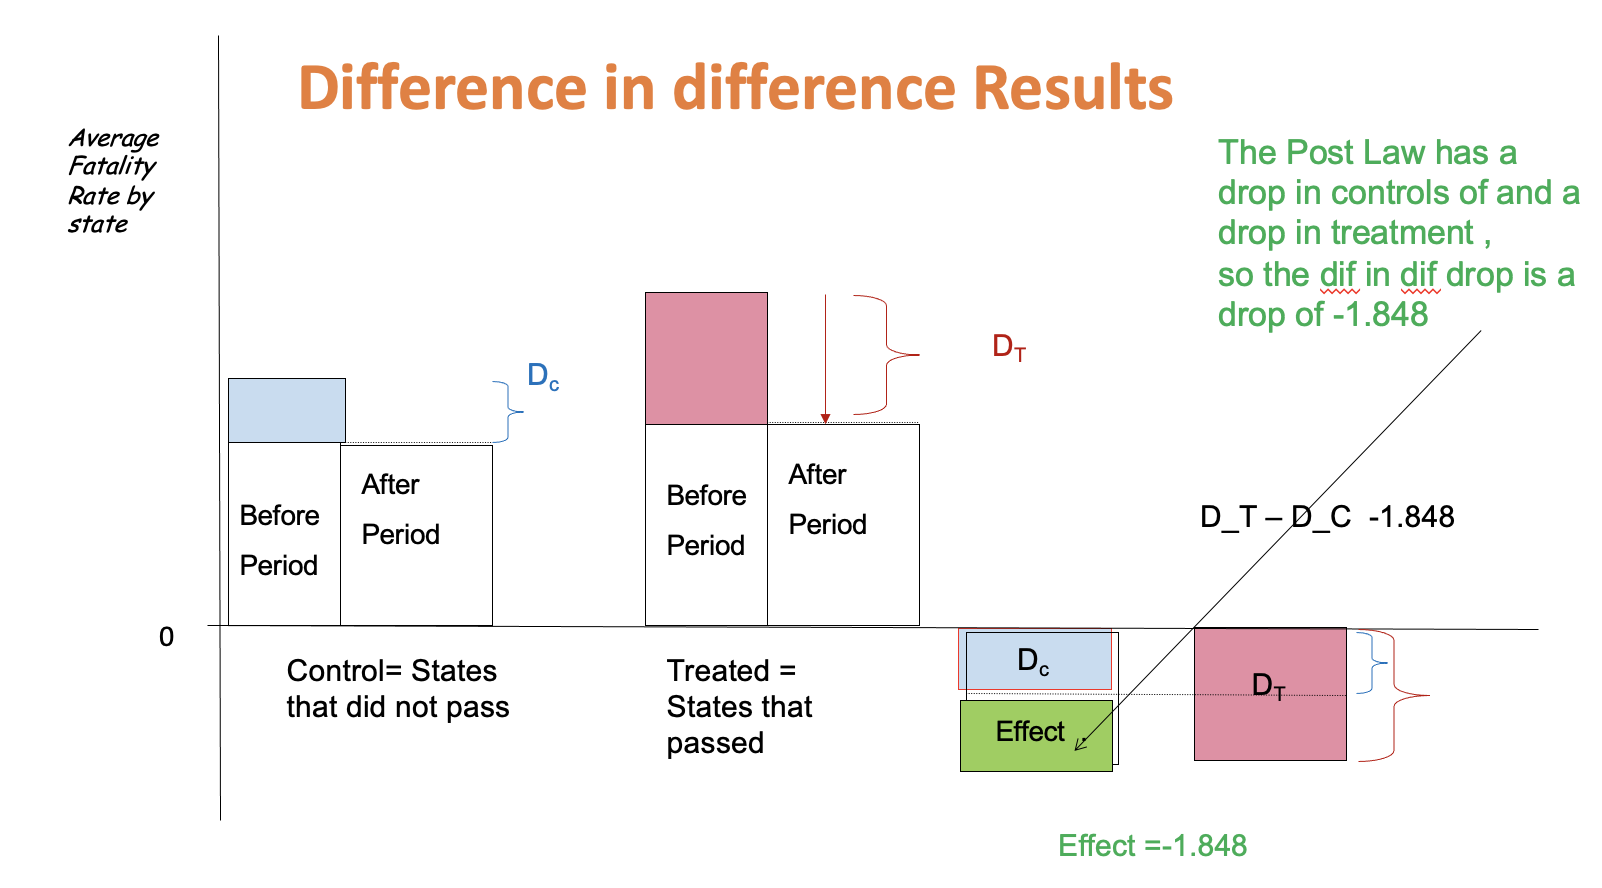